<a href="https://colab.research.google.com/github/yuvvantalreja/CAPTCHA-Image-Recognition-using-CRNN-and-BiGRU/blob/main/CAPTCHA_Text_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [1]:
import torch
from torch import nn

torch.__version__

'2.6.0+cu124'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Tue Jun  4 09:05:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import requests
import os
import zipfile
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim
import torch.nn.functional as F

## Data Preprocessing

In [ ]:
data_path = Path("")

# If image folder doesn't exist commence download
if data_path.is_dir():
  print(f"{data_path} directory already exists... skipping download")
else:
  print(f"Image path doesn't exist creating one...")
  data_path.mkdir(parents = True, exist_ok = True)

with open(data_path/"data.zip", "wb") as f:
  request = requests.get("https://github.com/yuvvantalreja/CAPTCHA-Image-Recognition-using-CRNN-and-BiGRU/raw/main/data.zip")
  print("Downloading data")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path/"data.zip", "r") as zip_ref:
  print("Unzipping data")
  zip_ref.extractall(data_path)

. directory already exists... skipping download
Unzipping data


In [ ]:
image_fns = os.listdir(data_path/"data")
print(len(image_fns))
print(np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns]))

1071
[0 5]


In [ ]:
for idx, image_fn in enumerate(image_fns):
    if len(image_fn.split(".")[0]) != 5:
           print(idx, image_fn)
           image_fns.remove(image_fn)

877 .DS_Store


In [ ]:
image_ns = [image_fn.split(".")[0] for image_fn in image_fns]
image_ns = "".join(image_ns)
letters = sorted(list(set(list(image_ns))))
print(len(letters))
print(letters)

19
['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [ ]:
vocabulary = ["-"] + letters
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

20
['-', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
{0: '-', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'm', 15: 'n', 16: 'p', 17: 'w', 18: 'x', 19: 'y'}
{'-': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'm': 14, 'n': 15, 'p': 16, 'w': 17, 'x': 18, 'y': 19}


In [ ]:
import random
from PIL import Image

image_path_list = list(data_path.glob("*/*.png"))
image_path_list[0]

PosixPath('data/wgnwp.png')

In [ ]:
# Split into train and test data
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(image_path_list, test_size = 0.2, train_size = 0.8, random_state = 42)

len(train_set), len(test_set)

(832, 208)

Image Label: nbfx5


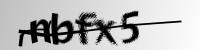

In [ ]:
random.seed(42)
random_img = random.choice(image_path_list)
img = Image.open(random_img).convert('RGB')
print(f"Image Label: {str(random_img.stem)}")
img

Text(0.5, 1.0, 'Image_Label: nbfx5 | Image Shape: (50, 200, 3)')

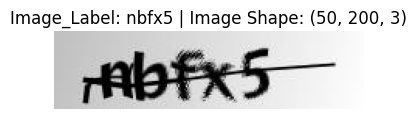

In [ ]:
img_as_array = np.asarray(img)

plt.figure(figsize = (4, 3))
plt.imshow(img_as_array)
plt.axis(False)
plt.title(f"Image_Label: {str(random_img.stem)} | Image Shape: {img_as_array.shape}")

In [ ]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Creating custom dataset

class CaptchaDataset(Dataset):
  def __init__(self, data_dir: str, image_fns: list):
    self.data_dir = data_dir
    self.image_fns = image_fns

  def __len__(self):
    return len(self.image_fns)

  def __getitem__(self, input: int):
    image_fn = self.image_fns[input]
    # image_fp = os.path.join(self.data_dir, image_fn)
    image = Image.open(image_fn).convert('RGB')
    image = self.transform(image)
    text = str(image_fn.stem)
    return image, text

  def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [ ]:
train_dataset = CaptchaDataset("data/", train_set)
test_dataset = CaptchaDataset("data/", test_set)
train_dataset.__getitem__(0)

(tensor([[[1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
          [1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
          [1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
          ...,
          [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318],
          [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318],
          [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318]],
 
         [[1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
          [1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
          [1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
          ...,
          [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111],
          [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111],
          [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111]],
 
         [[1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.5703],
          [1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.5703],
          [1.5420, 1.5420, 1.5420,  ...,

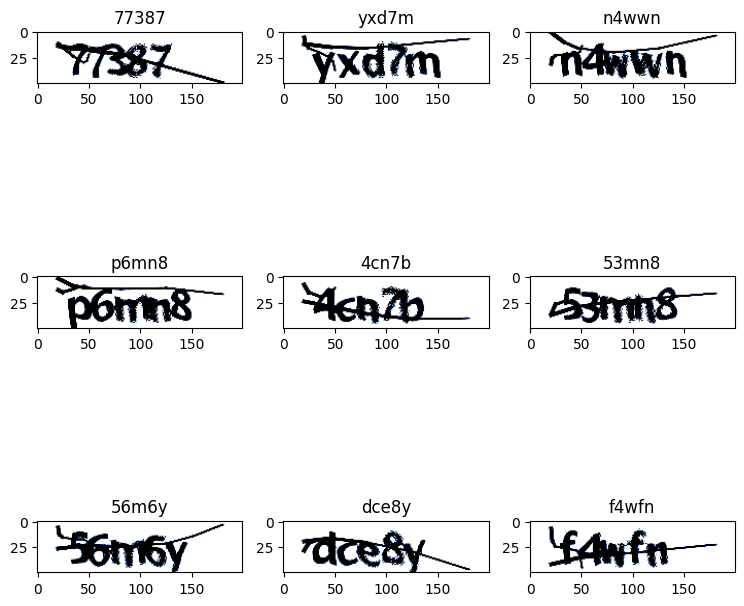

In [ ]:
torch.manual_seed(0)
fig = plt.figure(figsize = (9, 9))
rows, cols = 3, 3

for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, train_dataset.__len__(), size = [1]).item()
  image, labels = train_dataset[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze().permute(1, 2, 0))
  plt.title(train_set[random_idx].stem)
  plt.axis(True)

In [ ]:
os.cpu_count()

2

In [ ]:
# Dataloader

BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, num_workers = os.cpu_count(), shuffle = True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, num_workers = os.cpu_count(), shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x797eda269db0>,
 <torch.utils.data.dataloader.DataLoader at 0x797eda269270>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(52, 13)

In [ ]:
image_batch, text_batch = iter(train_dataloader).__next__()
print(image_batch.shape, len(text_batch))

torch.Size([16, 3, 50, 200]) 16


In [ ]:
image_batch[0]

tensor([[[1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
         [1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
         [1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
         ...,
         [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318],
         [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318],
         [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318]],

        [[1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
         [1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
         [1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
         ...,
         [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111],
         [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111],
         [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111]],

        [[1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.5703],
         [1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.5703],
         [1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.

## Model Creation

In [ ]:
num_chars = len(char2idx)
rnn_hidden_units = 256

In [ ]:
from torchvision.models import resnet18
resnet = resnet18(pretrained = True)
list(resnet.children())[:-3]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

* ResNet documentation: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html
* GRU Documentation: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
* GRU vs BiGRU: https://pub.aimind.so/what-is-the-difference-between-a-gru-and-a-bigru-fbde0fbe2950
* BiGRU Explained (Papers with Code): https://paperswithcode.com/method/bigru
* Paper on combining ResNet and BiGRU Techniques for OCR:  https://www.internationaljournalssrg.org/IJECE/2024/Volume11-Issue1/IJECE-V11I1P101.pdf

In [ ]:
class CRNN(nn.Module):
  def __init__(self, num_chars, rnn_hidden_units = 256, dropout = 0.1): # dropout --> used to reduce overfitting and memorization of trends in the data
    super().__init__()
    self.num_chars = num_chars
    self.rnn_hidden_units = rnn_hidden_units
    self.dropout = dropout

    resnet_modules = list(resnet.children())[:-3] # Using all except last 3 blocks of ResNet
    self.CNN1 = nn.Sequential(*resnet_modules)

    self.CNN2 = nn.Sequential(
        nn.Conv2d(256, 256, kernel_size = (3, 6), stride = 1, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True)
    )
    self.linear1 = nn.Linear(1024, 256)

    # RNN (BiGRU)

    self.rnn1 = nn.GRU(input_size = rnn_hidden_units,
                       hidden_size = rnn_hidden_units,
                       bidirectional = True,
                       batch_first = True
                       )
    self.rnn2 = nn.GRU(input_size = rnn_hidden_units,
                       hidden_size = rnn_hidden_units,
                       bidirectional = True,
                       batch_first = True
                       )
    self.linear2 = nn.Linear(self.rnn_hidden_units * 2, num_chars) # Why hidden_units * 2 ???

  def forward(self, batch):
        batch = self.CNN1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])

        batch = self.CNN2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])

        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])

        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])

        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])

        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])

        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])

        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])

        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])

        return batch

In [ ]:
# Initializing of weights using Xavier Uniform prevents vanishing or exploding gradients during training
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
crnn = CRNN(num_chars, rnn_hidden_units=rnn_hidden_units)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [ ]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('pybee', 'w46ep', '3ndxd', 'wc2bd', '8d8ep', 'ymp7g', 'w48cw', 'gxxpf', '4f8yp', '56m6y', 'cfn53', '5mcy7', 'n5n8b', 'mbp2y', '23mdg', 'ccn2x')
torch.Size([10, 16, 20])


In [ ]:
# Loss Definitions
loss_fn = nn.CTCLoss(blank = 0)

In [ ]:
def encode_text_batch(text_batch):

    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)

    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)

    return text_batch_targets, text_batch_targets_lens

In [ ]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),),
                                       fill_value=text_batch_logps.size(0),
                                       dtype=torch.int32).to(device) # [batch_size]
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens)
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = loss_fn(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [ ]:
compute_loss(text_batch, text_batch_logits)

tensor(4.5757, device='cuda:0', grad_fn=<MeanBackward0>)

## Training

In [ ]:
epochs = 50
lr = 0.01
decay = 1e-3
clip_norm = 5

In [ ]:
optimizer = torch.optim.Adam(params = crnn.parameters(), lr = lr, weight_decay = decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5) # makes lr dynamic to prevent vanishing/exploding gradients
optimizer

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.001
)

In [ ]:
crnn = CRNN(num_chars, rnn_hidden_units=rnn_hidden_units)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [ ]:
from timeit import default_timer as timer
def print_total_time(start, end):
    total_time = total_time = end-start
    print(f"Train time on {device}: {total_time: .3f} seconds")
    return total_time

In [ ]:
# Training loop

# Structure: optimizer.zero_grad() --> training logits --> computing loss --> backpropagation --> gradient descent

epoch_losses = []
iteration_losses = []
num_updates_epochs = []

start_time = timer()
for epoch in range(1, epochs + 1):

  epoch_loss_list = []
  num_updates_epoch = 0

  for image_batch, text_batch in train_dataloader:
    optimizer.zero_grad()
    text_batch_logits = crnn(image_batch.to(device))
    loss = compute_loss(text_batch, text_batch_logits)
    iteration_loss = loss.item()

    num_updates_epoch += 1
    iteration_losses.append(iteration_loss)
    epoch_loss_list.append(iteration_loss)
    loss.backward()

    # Gradient clipping used to prevent exploding gradients during training nn.
    # This becomes when the gradients become too large leading to instability and divergence during training.

    nn.utils.clip_grad_norm(crnn.parameters(), clip_norm)
    optimizer.step()

  epoch_loss = np.mean(epoch_loss_list)
  epoch_losses.append(epoch_loss)
  num_updates_epochs.append(num_updates_epoch)
  lr_scheduler.step(epoch_loss)
  if epoch % 5 == 0:
    print(f"Epoch: {epoch} | Validation Loss: {epoch_loss} | Updates: {num_updates_epoch}")
end_time = timer()
print(print_total_time(start_time, end_time))

<ipython-input-37-cfa0670582d6>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(crnn.parameters(), clip_norm)


Epoch: 5 | Validation Loss: 1.8237263399821062 | Updates: 52
Epoch: 10 | Validation Loss: 1.421118023303839 | Updates: 52
Epoch: 15 | Validation Loss: 1.3381443871901586 | Updates: 52
Epoch: 20 | Validation Loss: 1.3249430862756877 | Updates: 52
Epoch: 25 | Validation Loss: 1.2574848326352925 | Updates: 52
Epoch: 30 | Validation Loss: 1.2725717241947467 | Updates: 52
Epoch: 35 | Validation Loss: 1.0135237689201648 | Updates: 52
Epoch: 40 | Validation Loss: 0.9773287738745029 | Updates: 52
Epoch: 45 | Validation Loss: 0.9543556043734918 | Updates: 52
Epoch: 50 | Validation Loss: 0.9418224004598764 | Updates: 52
Train time on cuda:  81.661 seconds
81.66131738000001


Text(0, 0.5, 'Loss')

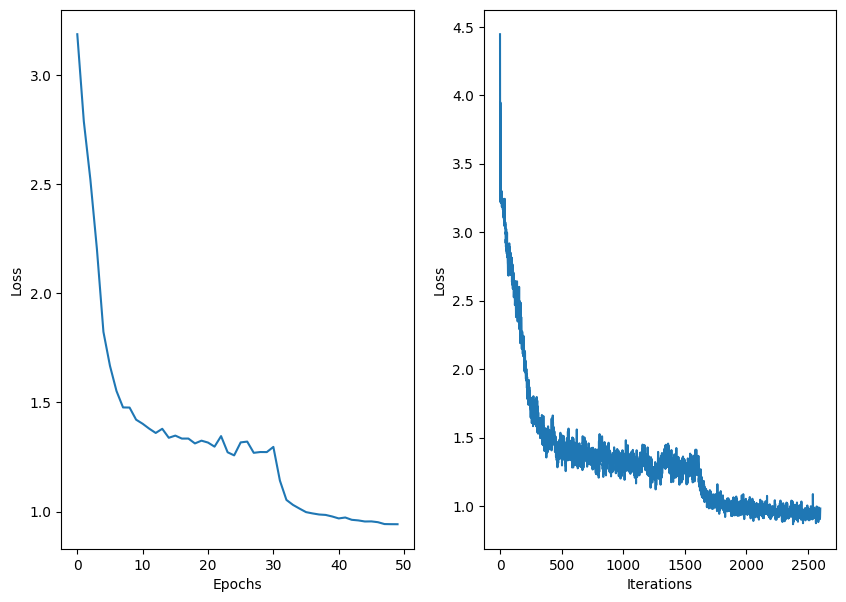

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 7))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

In [ ]:
# # Saving the model
# MODEL_PATH = Path("MODELS")

# MODEL_PATH.mkdir(parents = True, exist_ok = True)

# MODEL_NAME = 'weights01.pt'
# MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
# # torch.save(model, Path)
# print(MODEL_SAVE_PATH)
# torch.save(crnn.state_dict(), MODEL_SAVE_PATH)

## Making Predictions

In [ ]:
# Import trained weights from github

In [ ]:
# model = CRNN(num_chars, rnn_hidden_units=rnn_hidden_units)
# model.load_state_dict(torch.load(f = "/content/weights01.pt", map_location=torch.device(device)))

In [ ]:
def decode_predictions(text_batch_logits):
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=1, shuffle=False)
crnn.eval()
total_label_list = []
total_prediction_list = []
with torch.inference_mode():
  for image_batch, text_batch in tqdm(train_dataloader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        total_prediction_list.append(text_batch_pred)
        total_label_list.append(text_batch)

  0%|          | 0/52 [00:00<?, ?it/s]

In [ ]:
len(total_label_list), len(total_prediction_list)

(52, 52)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=1, shuffle=False)
crnn.eval()
total_test_label_list = []
total_test_pred_list = []
with torch.inference_mode():
  for image_batch, text_batch in tqdm(train_dataloader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        total_test_pred_list.append(text_batch_pred)
        total_test_label_list.append(text_batch)

  0%|          | 0/52 [00:00<?, ?it/s]

In [ ]:
len(total_test_label_list), len(total_test_pred_list)

(52, 52)

In [ ]:
import pandas as pd
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

  0%|          | 0/52 [00:00<?, ?it/s]

In [ ]:
print(results_train.shape)
results_train

(832, 2)


,actual,prediction
0,44ype,444yypee--
1,d7nn3,d77nnn3---
2,wm47f,wwmm477f--
3,56m6y,556mm6yy--
4,gw53m,ggww53mm--
...,...,...
827,mm3nn,mmm3n--n--
828,25257,2552577---
829,6b46g,66b466gg--
830,f753f,f7753ff---


In [ ]:
# Removing duplicate characters

def remove_duplicates(text):
  if len(text) > 1:
    letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start = 1) if text[idx] != text[idx-1]] #????
  elif len(text) == 1:
    letters = text[0]
  else:
    return ""
  return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [ ]:
text_batch_pred[1]

'3xxngg66--'

In [ ]:
total_prediction_list[0][0]

'bbpwwd77--'

In [ ]:
corrected_predictions = []
for preds in range(len(total_prediction_list)):
  for batches in range(len(total_prediction_list[preds])):
    corrected_predictions.append(correct_prediction(total_prediction_list[preds][batches]))
    # print(f"True Labels: {text_batch[preds]} | Predictions: {text_batch_pred[preds]} | Corrected Predictions {correct_prediction(text_batch_pred[preds])}")

In [ ]:
corrected_test_predictions = []
for preds in range(len(total_test_pred_list)):
  for batches in range(len(total_test_pred_list[preds])):
    corrected_test_predictions.append(correct_prediction(total_test_pred_list[preds][batches]))
    # print(f"True Labels: {text_batch[preds]} | Predictions: {text_batch_pred[preds]} | Corrected Predictions {correct_prediction(text_batch_pred[preds])}")

In [ ]:
# Calculating mistakes {real: prediction}
mistakes = {}
for preds in range(len(total_label_list)):
  for batches in range(len(total_label_list[preds])):
    if total_label_list[preds][batches] != corrected_predictions[batches]:
      mistakes[total_label_list[preds][batches]] = corrected_predictions[batches]
len(corrected_predictions) - len(mistakes)

11

In [ ]:
# Calculating mistakes {real: prediction}
test_mistakes = {}
for preds in range(len(total_test_label_list)):
  for batches in range(len(total_test_label_list[preds])):
    if total_test_label_list[preds][batches] != corrected_test_predictions[batches]:
      mistakes[total_test_label_list[preds][batches]] = corrected_test_predictions[batches]
len(corrected_test_predictions) - len(test_mistakes)

832

In [ ]:
label_list = []
for preds in range(len(total_label_list)):
  for batches in range(len(total_label_list[preds])):
    label_list.append(total_label_list[preds][batches])

In [ ]:
# Calculating Batch Accuracy
correct = 0
for preds in range(len(text_batch_pred)):
  correct_preds = correct_prediction(text_batch_pred[preds])
  if text_batch[preds] == correct_preds:
    correct += 1
acc = correct/len(text_batch_pred)
print(acc)

0.9375


In [ ]:
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(label_list, corrected_predictions)
print(train_accuracy)
# test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
# print(test_accuracy)

0.7644230769230769


## Loading pretrained CRNN Model